# import packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
# import matrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools 

# call the dataset

In [7]:
ds_asl_dir = r"data"
asl_ds = tf.keras.preprocessing.image_dataset_from_directory(ds_asl_dir)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

print(pd.DataFrame(asl_ds.class_names))

for image_batch, labels_batch in asl_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 3311 files belonging to 11 classes.
          0
0         1
1         2
2         3
3         4
4         5
5         6
6         7
7         8
8         9
9      done
10  notdone
(32, 256, 256, 3)
(32,)


# visualize the raw dataset

Image sample with width=200 and height=200.


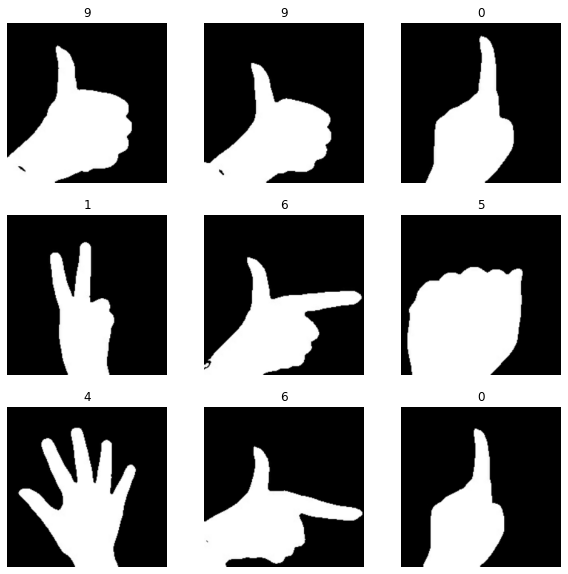

In [8]:
from PIL import Image 
img = Image.open(r"data/1/1.jpg")
width, height = img.size
print(f"Image sample with width={width} and height={height}.")

plt.figure(figsize=(10, 10))
for images, labels in asl_ds.take(1):

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        plt.title(int(labels[i]))
        plt.axis("off")
    plt.show()


# detect any corrupted image

In [9]:
batch_size = 32
img_height = 64
img_width = 64
#
import os
num_skipped = 0
for folder_name in ("1","2","3","4","5","6","7","8","9","done","notdone"):
    folder_path = os.path.join(ds_asl_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 0 images


# train/test split

In [14]:
from keras.preprocessing.image import ImageDataGenerator
data_augmentation = ImageDataGenerator(rotation_range=15, rescale=1/255, zoom_range=0.1, horizontal_flip=True,
                                       width_shift_range=0.1, height_shift_range=0.1, validation_split=0.2)

#Setting train/test split

asl_train_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),
                                                     class_mode="categorical", batch_size=batch_size, subset="training")
asl_test_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),
                                                    class_mode="categorical", batch_size=batch_size, subset="validation",shuffle=False)
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense

#Checking if the data format i.e the RGB channel is coming first or last so, whatever it may be, model will check first and then input shape will be feeded accordingly.

from keras import backend as K
if K.image_data_format() == "channels_first":
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)


Found 2651 images belonging to 11 classes.
Found 660 images belonging to 11 classes.


# Creating a model

In [15]:

model_dl = keras.Sequential()
model_dl.add(Conv2D(32,(3,3),activation="relu",input_shape=(input_shape)))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(32,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(64,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Flatten())
model_dl.add(Dense(128,activation="relu"))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(11,activation="softmax"))

model_dl.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_dl.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 14, 14, 32)       

# Fitting to the model

In [16]:


from keras.callbacks import EarlyStopping,ReduceLROnPlateau #Import callback functions
earlystop=EarlyStopping(patience=10) #Monitor the performance. If it dips, then stop training
learning_rate_reduce=ReduceLROnPlateau(monitor="val_accuracy",min_lr=0.001) #Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]

In [19]:
history=model_dl.fit(asl_train_ds, validation_data=asl_test_ds, epochs=50)


Epoch 1/50
83/83 [==============================] - 14s 164ms/step - loss: 0.2326 - accuracy: 0.9276 - val_loss: 0.1067 - val_accuracy: 0.9652
Epoch 2/50
83/83 [==============================] - 12s 143ms/step - loss: 0.1658 - accuracy: 0.9415 - val_loss: 0.0757 - val_accuracy: 0.9712
Epoch 3/50
83/83 [==============================] - 13s 155ms/step - loss: 0.1236 - accuracy: 0.9566 - val_loss: 0.0845 - val_accuracy: 0.9773
Epoch 4/50
83/83 [==============================] - 13s 151ms/step - loss: 0.0852 - accuracy: 0.9736 - val_loss: 0.0547 - val_accuracy: 0.9833
Epoch 5/50
83/83 [==============================] - 12s 146ms/step - loss: 0.0836 - accuracy: 0.9743 - val_loss: 0.0831 - val_accuracy: 0.9803
Epoch 6/50
83/83 [==============================] - 17s 200ms/step - loss: 0.0760 - accuracy: 0.9743 - val_loss: 0.0353 - val_accuracy: 0.9879
Epoch 7/50
83/83 [==============================] - 12s 147ms/step - loss: 0.0551 - accuracy: 0.9815 - val_loss: 0.0794 - val_accuracy: 0.9773

# save the model

In [21]:
model_dl.save("model.h5")


# load the model

In [22]:
model_dl = keras.models.load_model(r"model.h5")

# evaluation of the model

In [23]:
model_dl = keras.models.load_model(r"model.h5")
from keras.utils import Sequence 
test_score = model_dl.evaluate(asl_test_ds)

21/21 [==============================] - 1s 59ms/step - loss: 0.0275 - accuracy: 0.9924


# accuracy of HGVS model

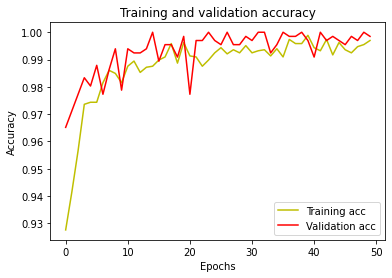

In [24]:
# print(model_dl.history.keys())
# summarize history for accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, 'y', label='Training acc')
plt.plot(val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Loss of model

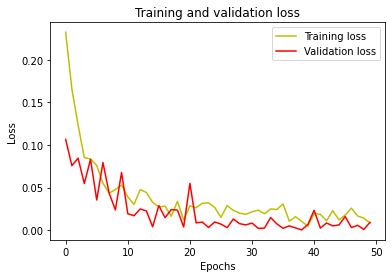

In [25]:
# summarize history for loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(loss, 'y', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
model_dl = keras.models.load_model(r"model.h5")

# confusion matrix

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools 

target_names = []
for key in asl_train_ds.class_indices:
    target_names.append(key)

In [29]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

21/21 [==============================] - 1s 60ms/step
Confusion Matrix
Confusion matrix, without normalization


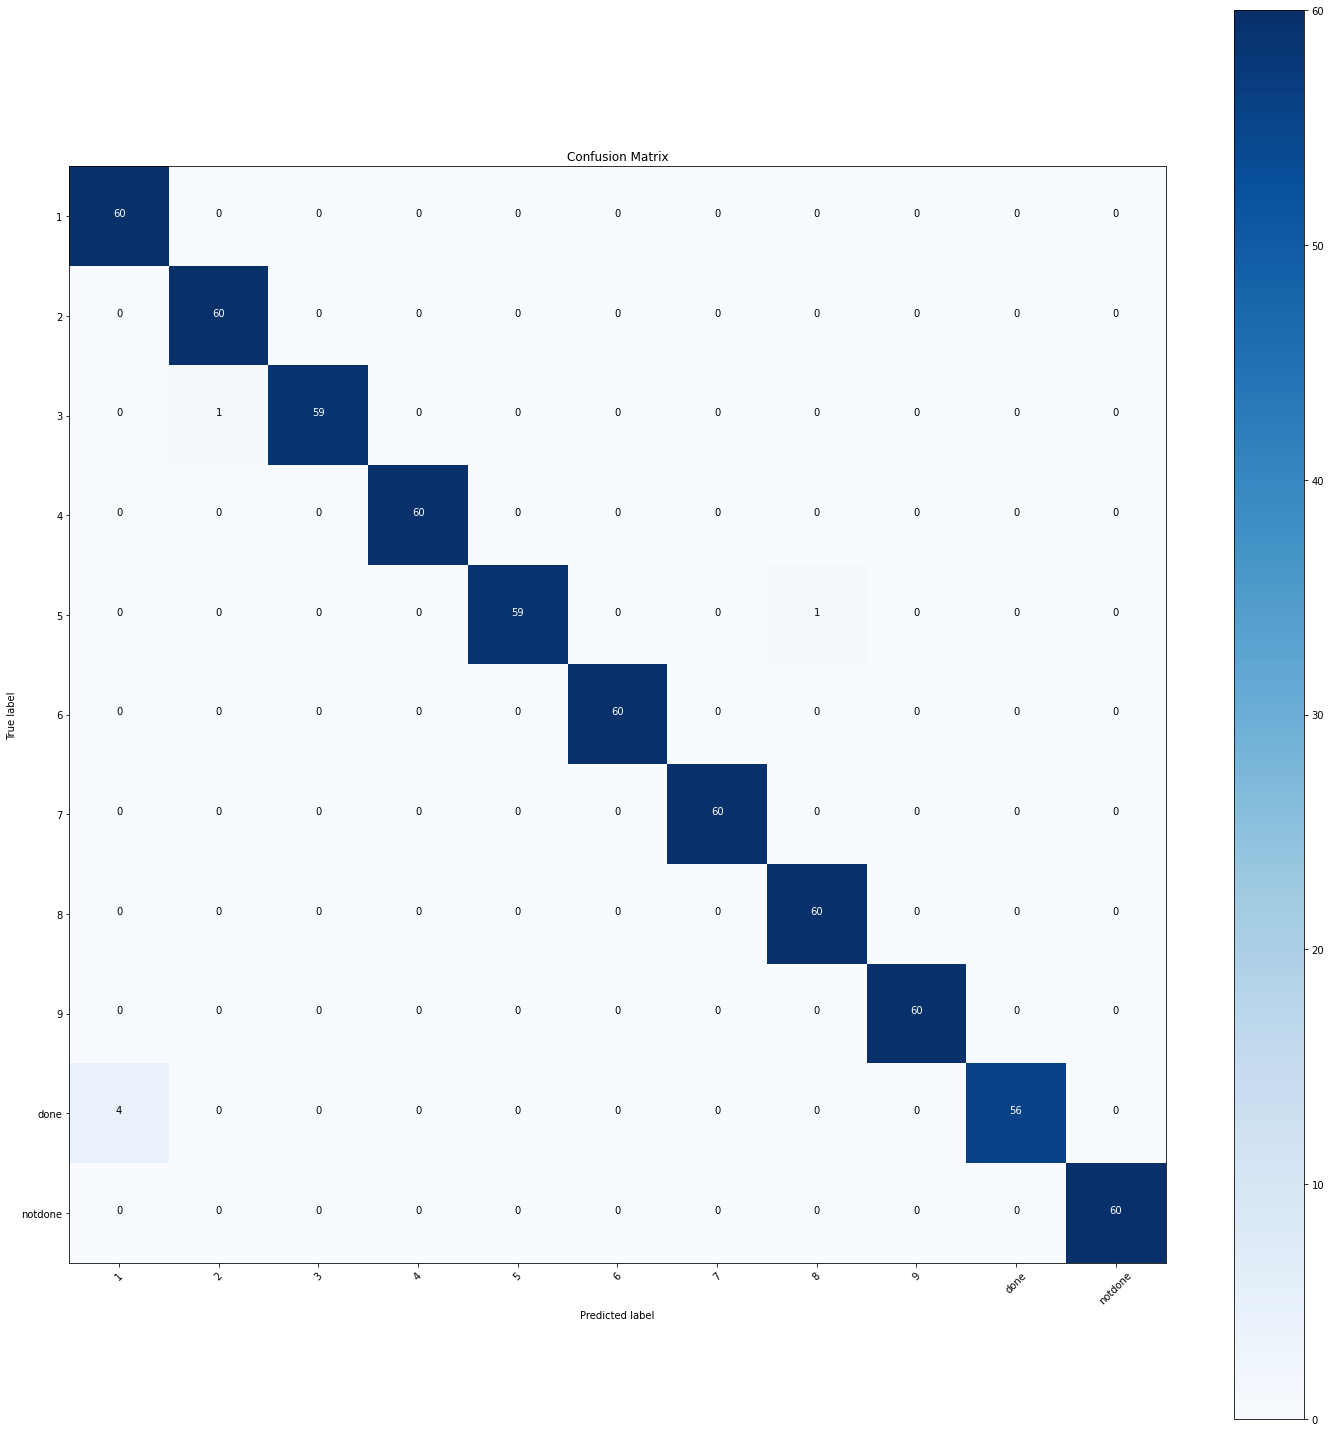

In [30]:
#Confution Matrix and Classification Report
Y_pred = model_dl.predict(asl_test_ds)
y_pred = np.argmax(Y_pred, axis=-1)
print('Confusion Matrix')
cm=confusion_matrix(asl_test_ds.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [31]:
print('Classification Report')
print(classification_report(asl_test_ds.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        60
           2       0.98      1.00      0.99        60
           3       1.00      0.98      0.99        60
           4       1.00      1.00      1.00        60
           5       1.00      0.98      0.99        60
           6       1.00      1.00      1.00        60
           7       1.00      1.00      1.00        60
           8       0.98      1.00      0.99        60
           9       1.00      1.00      1.00        60
        done       1.00      0.93      0.97        60
     notdone       1.00      1.00      1.00        60

    accuracy                           0.99       660
   macro avg       0.99      0.99      0.99       660
weighted avg       0.99      0.99      0.99       660

